In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
class Receiver(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M)

    def forward(self, y):
        y = self.lin1(y)
        return y

class Encoder(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(1, M, bias=False)
        nn.init.constant_(self.lin1.weight, 1 / M)
        self.out = nn.Softmax(dim=0)

    def forward(self, y):
        return self.out(self.lin1(y))

class Mapper(nn.Module):
    def __init__(self, M):
        super().__init__()
        self.lin1 = nn.Linear(M, 1)

    def forward(self, y):
        y = self.lin1(y)
        return y

In [4]:
def sampler(prob, n):
    samples = torch.empty(0)
    for idx, p in enumerate(prob):
        occurrences = torch.round(n * p).type(torch.LongTensor)
        samples = torch.cat((samples, torch.ones(occurrences, dtype=torch.int64) * torch.tensor(idx)))
    indexes = torch.randperm(samples.shape[0])
    return samples[indexes]

def gradient_correction_factor(app, idx, prob, M):
    (nn,M)= app.shape
    cf  = torch.zeros(M)
    for j in range(M):
        tmp = app[:, j]
        cf[j] = torch.sum(torch.log(tmp[idx==j])) / (nn*prob[j]) # tmp[idx==j] selects the ll of those xy pairs which belong to the current symbol j
    return cf

In [5]:
def AWGN_channel(x, sigma2):
    noise_t = np.sqrt(sigma2)*torch.randn(x.shape)
    return x + noise_t

In [6]:
M = 8
n = 10_000
nepochs = 4000
lr = 0.01

dec = Receiver(M)
enc = Encoder(M)
mapper = Mapper(M)
loss_fn = nn.CrossEntropyLoss()

# alphabet = np.arange(-(M-1),M,2)
# #alphabet = np.array([-10, -6, -3, -1, 1, 3, 6, 10]) <-- Non-uniform alphabet
# alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
# alphabet_t = torch.tensor(alphabet).float()

In [7]:
def train_encoder_at_dB(dB, report=False):
    SNR_dB = dB
    SNR = 10**(SNR_dB/10)
    sigma2 = 1/SNR

    opt = optim.Adam( list(enc.parameters()) + list(dec.parameters()) + list(mapper.parameters()), lr=lr)

    for j in range(nepochs):
        probs = enc(torch.tensor([1], dtype=torch.float))

        # Sample indexes
        indices = sampler(probs, n)
        indices = indices.type(torch.LongTensor)

        # Modulation
        alphabet_t = mapper(nn.functional.one_hot(torch.arange(M),M).float()).squeeze()
        norm_factor = torch.rsqrt(torch.sum(torch.pow(torch.abs(alphabet_t), 2) * probs))
        alphabet_norm =  alphabet_t * norm_factor
        onehot = nn.functional.one_hot(indices, M).float()
        symbols = torch.matmul(onehot, torch.transpose(input=alphabet_norm.reshape(1,-1), dim0=0, dim1=1))

        # Channel
        y = AWGN_channel(symbols, sigma2)

        # Demodulator
        ll = dec(y.reshape(-1,1).float())
        app = nn.functional.softmax(ll, 1) #Q(X|Y)

        # Loss
        loss = -(torch.sum(-probs*torch.log(probs)) - loss_fn(ll, indices))# -(H(X) - CE(P,Q)), the gradient descent minimizes, therefore we minimize the opposite to maximize the MI in the end.
        opt.zero_grad()
        loss.backward()


        # correction factor
        cf = - (gradient_correction_factor(app, indices, probs, M) - torch.log(probs)).detach()

        # if report and j % 500 == 0:
        #     print('missing factors: ', cf.detach().numpy())
        #     print('current grad: ', probs.grad.detach().numpy())

        probs.register_hook(lambda grad: grad + cf)

        opt.step()

        # Printout and visualization
        if report and j % 500 == 0:
            print(f'epoch {j}: Loss = {loss.detach().numpy() / np.log(2) :.4f}')

    if report:
        print('probs: ', probs)
        plt.hist(symbols.detach().numpy(), bins=100)
        plt.show()

    return loss

### Compare Results

In [8]:
def AWGN_channel_np(x, sigma2):
    noise = np.sqrt(sigma2) * np.random.randn(x.size)
    return x + noise

In [9]:
def AWGNdemapper(y, const, varN):
    apps = np.exp(-np.abs(np.transpose([y])-const)**2/(2*varN))
    return apps / np.transpose([np.sum(apps, 1)])

In [10]:
def xesmd(apps, idx):
    """
    Estimates symbolwise equivocation from reference symbols indices and a posteriori probabilities.
    """
    eq = -np.log(np.take_along_axis(apps, idx[:, None], axis=1) / np.transpose([np.sum(apps, 1)]))
    eq[eq==np.inf] = 1000
    return np.mean(eq)

In [39]:
n = 100_000
SNR_dBs = np.arange(5,22)
M = 8
alphabet = np.arange(-7,8,2)
alphabet = alphabet / np.sqrt(np.mean(alphabet**2))
indices = np.random.choice(np.arange(M), n)
symbols = alphabet[indices]

mi_64 = []
mi_pas = []
for snrdB in SNR_dBs:
    print('SNR: ', snrdB)
    sigma2 = 1/(10**(snrdB/10))
    sigma2 = sigma2 
    y = AWGN_channel_np(symbols, sigma2)
    apps = AWGNdemapper(y, alphabet, sigma2)
    xe = xesmd(apps, indices)
    mi_64.append(2*(3 - (xe) / np.log(2)))

    mi_pas.append((-2*train_encoder_at_dB(snrdB, report=True)/torch.log(torch.tensor(2))).detach().numpy().tolist())

SNR:  5
SNR:  6
SNR:  7
SNR:  8
SNR:  9
SNR:  10
SNR:  11
SNR:  12
SNR:  13
SNR:  14
SNR:  15
SNR:  16
SNR:  17
SNR:  18
SNR:  19
SNR:  20
SNR:  21


In [18]:
mi_pas2 = []
for idx, mi in enumerate(mi_pas):
    mi_pas2.append(mi.detach().numpy().tolist())
print(mi_pas2)
print(len(SNR_dBs))

[2.056528329849243, 2.3185625076293945, 2.580800771713257, 2.8667778968811035, 3.1524178981781006, 3.4508140087127686, 3.7533507347106934, 4.054192543029785, 4.343872547149658, 4.6285905838012695, 4.899359226226807, 5.141739845275879, 5.368502616882324, 5.556087017059326, 5.701193332672119, 5.820334434509277, 5.904704570770264]
17


In [36]:
mi_pcs = [2.029059226081356, 2.2978030999378998, 2.5704382532528656, 2.853178763167228, 3.140069558412212, 3.4417821624738543, 3.741886040819326, 4.044889202693043, 4.3464882982051165, 4.627299850707401, 4.898118179298653, 5.140992078847111, 5.355220204102558, 5.551162445987668, 5.6973077992460555, 5.816026047275445, 5.896279343543463]

mi_geo_pcs = [2.056528329849243, 2.3185625076293945, 2.580800771713257, 2.8667778968811035, 3.1524178981781006, 3.4508140087127686, 3.7533507347106934, 4.054192543029785, 4.343872547149658, 4.6285905838012695, 4.899359226226807, 5.141739845275879, 5.368502616882324, 5.556087017059326, 5.701193332672119, 5.820334434509277, 5.904704570770264]

Text(0.5, 0, 'SNR in dB')

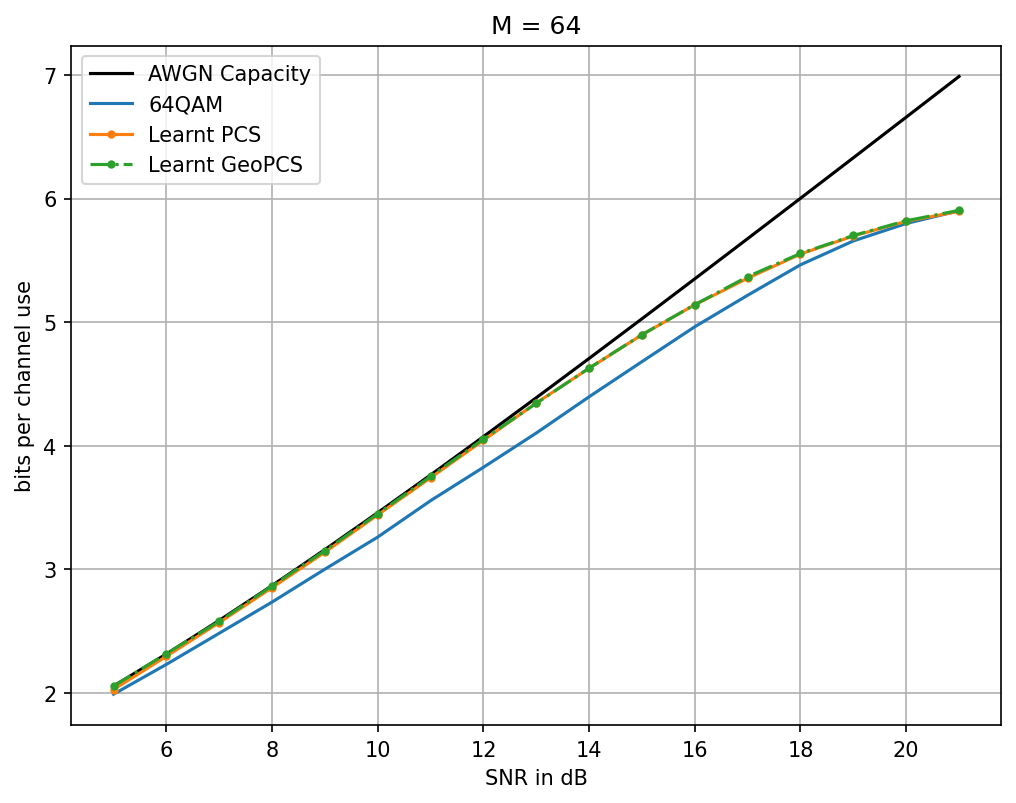

In [50]:
# Plot
plt.rcParams['figure.figsize'] = [8, 6]

plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
plt.plot(SNR_dBs, mi_64, label = '64QAM')
# plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)) - 0.5*np.log2((np.pi*np.e)/6) , linestyle='dashed', color='C4', label='$C(P/\sigma^2) - \dfrac{1}{2}\log_2\dfrac{\pi e}{6}$')

plt.plot(SNR_dBs, mi_pcs, marker='o', markersize=3, label='Learnt PCS')

plt.plot(SNR_dBs, mi_geo_pcs, marker='o', markersize=3, ls='-.', label='Learnt GeoPCS')
#for xy in zip(SNR_dBs, mi_pas2):
#    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.legend()
plt.grid()
plt.title('M = 64')
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')

Text(0.5, 0, 'SNR in dB')

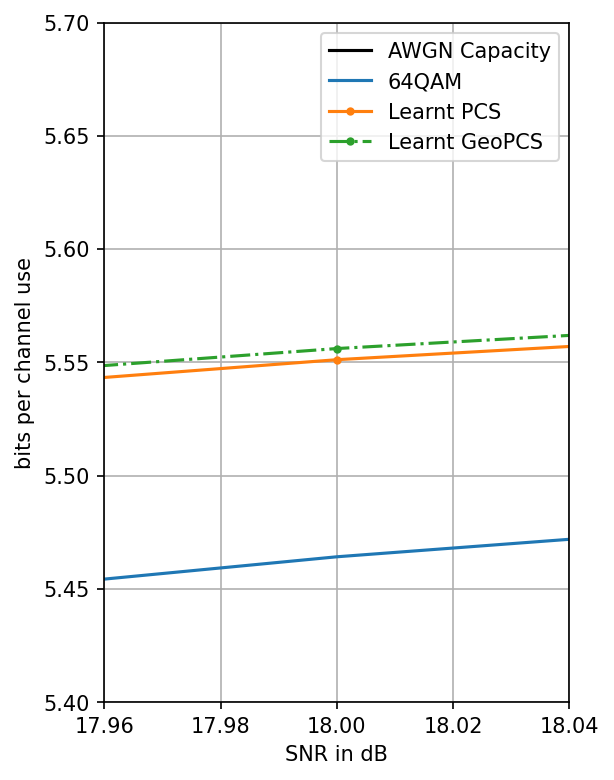

In [48]:
plt.rcParams['figure.figsize'] = [4, 6]
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='black', label='AWGN Capacity')
plt.plot(SNR_dBs, mi_64, label = '64QAM')
# plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)) - 0.5*np.log2((np.pi*np.e)/6) , linestyle='dashed', color='C4', label='$C(P/\sigma^2) - \dfrac{1}{2}\log_2\dfrac{\pi e}{6}$')

plt.plot(SNR_dBs, mi_pcs, marker='o', markersize=3, label='Learnt PCS')

plt.plot(SNR_dBs, mi_geo_pcs, marker='o', markersize=3, ls='-.', label='Learnt GeoPCS')
#for xy in zip(SNR_dBs, mi_pas2):
#    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.legend()
plt.grid()
plt.ylim([5.4,5.7])
plt.xlim([17.96,18.04])
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')

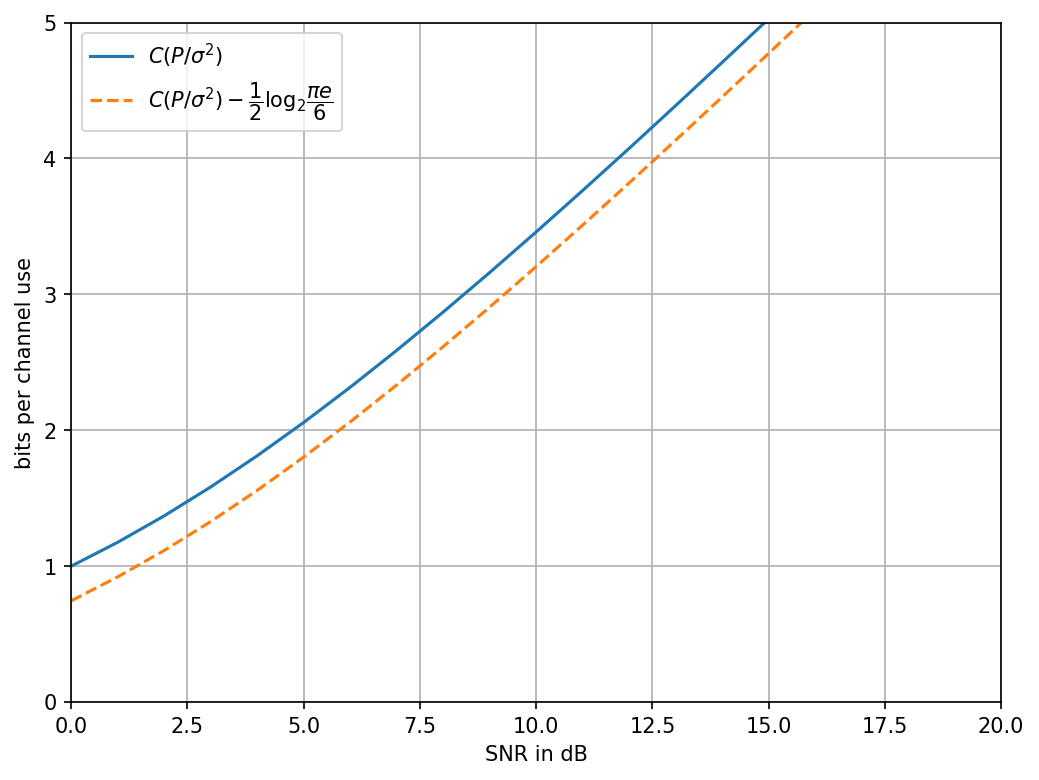

In [30]:
SNR_dBs = np.arange(0,20)
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)), color='C0', label='$C(P/\sigma^2)$')
plt.plot(SNR_dBs, np.log2(1+10**(SNR_dBs/10)) - 0.5*np.log2((np.pi*np.e)/6) , linestyle='dashed', color='C1', label='$C(P/\sigma^2) - \dfrac{1}{2}\log_2\dfrac{\pi e}{6}$')
plt.grid()
plt.ylabel('bits per channel use')
plt.xlabel('SNR in dB')
plt.xlim([0, 20])
plt.ylim([0, 5])
# plt.title('AWGN channel capacity gap')
plt.legend()